In [1]:
import warnings
warnings.filterwarnings('ignore')

import urllib, json
from urllib.request import urlopen
import numpy as np
from io import open
import ast
import time
import requests
import pandas as pd

from IPython.core.display import HTML,display
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'


from collections import Counter

In [14]:
fields = pd.read_excel("arrs_klasifikacija.xlsx",sheet_name="področja",header=None,dtype=str)
#kys = ('employs','cit','classificationFrascati','evaluation',"programs")
kys = ('employs','cit','classificationFrascati','evaluation')
vede = pd.read_excel("arrs_klasifikacija.xlsx",sheet_name="vede",header=None,dtype=str)

In [16]:
f = '1.02'
fields[fields[0] == f][1].values[0]

'Fizika'

In [2]:
def get_rows_by_org_unit(df, org_unit_short_name):
    """
    Returns a DataFrame containing all rows for the given organizational unit short name.
    
    Parameters:
    df (DataFrame): The original DataFrame containing the data.
    org_unit_short_name (str): The short name of the organizational unit to filter by.

    Returns:
    DataFrame: A filtered DataFrame containing only rows matching the given organizational unit.
    """
    filtered_df = df[df['Kratek naziv OE 2'] == org_unit_short_name].copy()
    return filtered_df

In [3]:
# read to dataframe from xlsx
df = pd.read_excel('data.xlsx', sheet_name='Sheet1')

In [4]:
# Compute weights for 'Delež DM' for each researcher such that their weights sum to 1
df['Delež DM utež'] = df['Delež DM'] / df.groupby('Osebna številka')['Delež DM'].transform('sum')


In [5]:
vec_fields_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
vec_fields = np.array([0,0,0,0,0,0,0])
c = 0
f = 0
for index, row in df.iterrows():
    c += 1
    f += row['Delež DM utež']
    r = row['raziskovalno področje']
    r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
    for i in r:
        if i <= 7:
            pos = int(i) - 1
            vec_fields_weight[pos] += row['Delež DM utež']
            vec_fields[pos] += 1

In [6]:
c, f

(2221, 1152.0000000000025)

In [7]:
vec_fields_weight

array([187., 442., 142.,  52., 309., 115.,  48.])

In [8]:
vec_fields.sum(), vec_fields_weight.sum()

(np.int64(2567), np.float64(1295.0))

In [9]:
vec_fields_weight / vec_fields_weight.sum(), vec_fields/vec_fields.sum()

(array([0.14440154, 0.34131274, 0.10965251, 0.04015444, 0.23861004,
        0.08880309, 0.03706564]),
 array([0.13400857, 0.32956759, 0.10518115, 0.03700818, 0.26606934,
        0.09193611, 0.03622906]))

In [215]:
# find 15413 in ARRS šifra
df.loc[df['ARRS šifra'] == 15413]['raziskovalno področje']

1113    ['1.02', '3.07']
1114    ['1.02', '3.07']
Name: raziskovalno področje, dtype: object

In [216]:
r = df.loc[df['ARRS šifra'] == 15413]['raziskovalno področje'].values[0]

In [217]:
r

"['1.02', '3.07']"

In [218]:
ast.literal_eval(r)

['1.02', '3.07']

In [221]:
list(set([int(x[0]) for x in ast.literal_eval(r)]))

[1, 3]

In [244]:
fgpa = get_rows_by_org_unit(df, 'FGPA')

In [17]:
#### ZNANSTVENE VEDE ####

faculty = 'FKKT'

df_faculty = df[df['Kratek naziv OE 2'] == faculty]
vec_fields_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
vec_fields = np.array([0,0,0,0,0,0,0])
c = 0
f = 0
id = []
weights = []
sum_sicris_eff = 0
sum_sicris_imp = 0
vec_sicris = []

for index, row in df_faculty.iterrows():
    c += 1
    f += row['Delež DM utež']
    weights.append(row['Delež DM utež'])
    id.append(row['ARRS šifra'])
    r = row['raziskovalno področje']
    r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
    q = row['Delež DM utež']
    if row['WOS članki'] > 0 and row['A1/2'] > 0:
        #vec_sicris += q * row["WOS čisti citati"]/row["WOS članki"]
        vec_sicris.append(q * row["CI10"]/row["A1/2"])
        sum_sicris_eff += q * row["A3"] * row["CI10"]/row["upoštevane točke"]
        sum_sicris_imp += q * row["CI10"]/row["A1/2"]

    for i in r:
        if i <= 7:
            pos = int(i) - 1
            vec_fields_weight[pos] += q
            vec_fields[pos] += 1

In [21]:
faculties = np.array(['FKKT', 'FS', 'FOV', 'EPF', 'FGPA', 'MF', 'FERI', 'FF', 'PF',
       'FVV', 'FKBV', 'FL', 'FT', 'FNM', 'PEF', 'FZV', 'FE'])

In [511]:
resvec = []
fname = []
for faculty in faculties:
    df_faculty = df[df['Kratek naziv OE 2'] == str(faculty)]
    vec_fields_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
    vec_fields = np.array([0,0,0,0,0,0,0])
    c = 0
    f = 0
    id = []
    weights = []
    sum_sicris_eff = 0
    sum_sicris_imp = 0
    vec_sicris = []

    for index, row in df_faculty.iterrows():
        c += 1
        f += row['Delež DM utež']
        weights.append(row['Delež DM utež'])
        id.append(row['ARRS šifra'])
        r = row['raziskovalno področje']
        r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
        q = row['Delež DM utež']
        if row['WOS članki'] > 0 and row['A1/2'] > 0:
            #vec_sicris += q * row["WOS čisti citati"]/row["WOS članki"]
            vec_sicris.append(q * row["CI10"]/row["A1/2"])
            sum_sicris_eff += q * row["A3"] * row["CI10"]/row["upoštevane točke"]
            sum_sicris_imp += q * row["CI10"]/row["A1/2"]

        for i in r:
            if i <= 7:
                pos = int(i) - 1
                vec_fields_weight[pos] += q
                vec_fields[pos] += 1

    resvec.append(vec_fields_weight / vec_fields_weight.sum())
    fname.append(str(faculty))
    print(faculty, vec_fields_weight / vec_fields_weight.sum())
        

FKKT [0.40080147 0.51946145 0.02883839 0.04014721 0.00125853 0.
 0.00949294]
FS [0.09302613 0.85068811 0.         0.0074223  0.04144116 0.
 0.0074223 ]
FOV [0.07663651 0.28738691 0.01596594 0.         0.58807877 0.01596594
 0.01596594]
EPF [0.02538276 0.05235194 0.         0.         0.82416094 0.04905218
 0.04905218]
FGPA [0.09768489 0.62460124 0.01172083 0.01289291 0.24020721 0.01289291
 0.        ]
MF [0.24666255 0.0568433  0.66070764 0.01206713 0.02371937 0.
 0.        ]
FERI [0.03817938 0.78064675 0.00557801 0.00535489 0.03212936 0.03748425
 0.10062736]
FF [0.00730481 0.         0.03151304 0.         0.25410491 0.64372377
 0.06335347]
PF [0.         0.         0.03545052 0.         0.92909897 0.03545052
 0.        ]
FVV [0.03399433 0.13597734 0.         0.         0.74787535 0.04815864
 0.03399433]
FKBV [0.19831606 0.05340664 0.         0.65868189 0.03618876 0.
 0.05340664]
FL [0.08276313 0.2666812  0.         0.         0.58793157 0.05889976
 0.00372434]
FT [0.         0.02744739

In [528]:
np.save('resvec.npy', resvec)
np.save('fname.npy', fname)

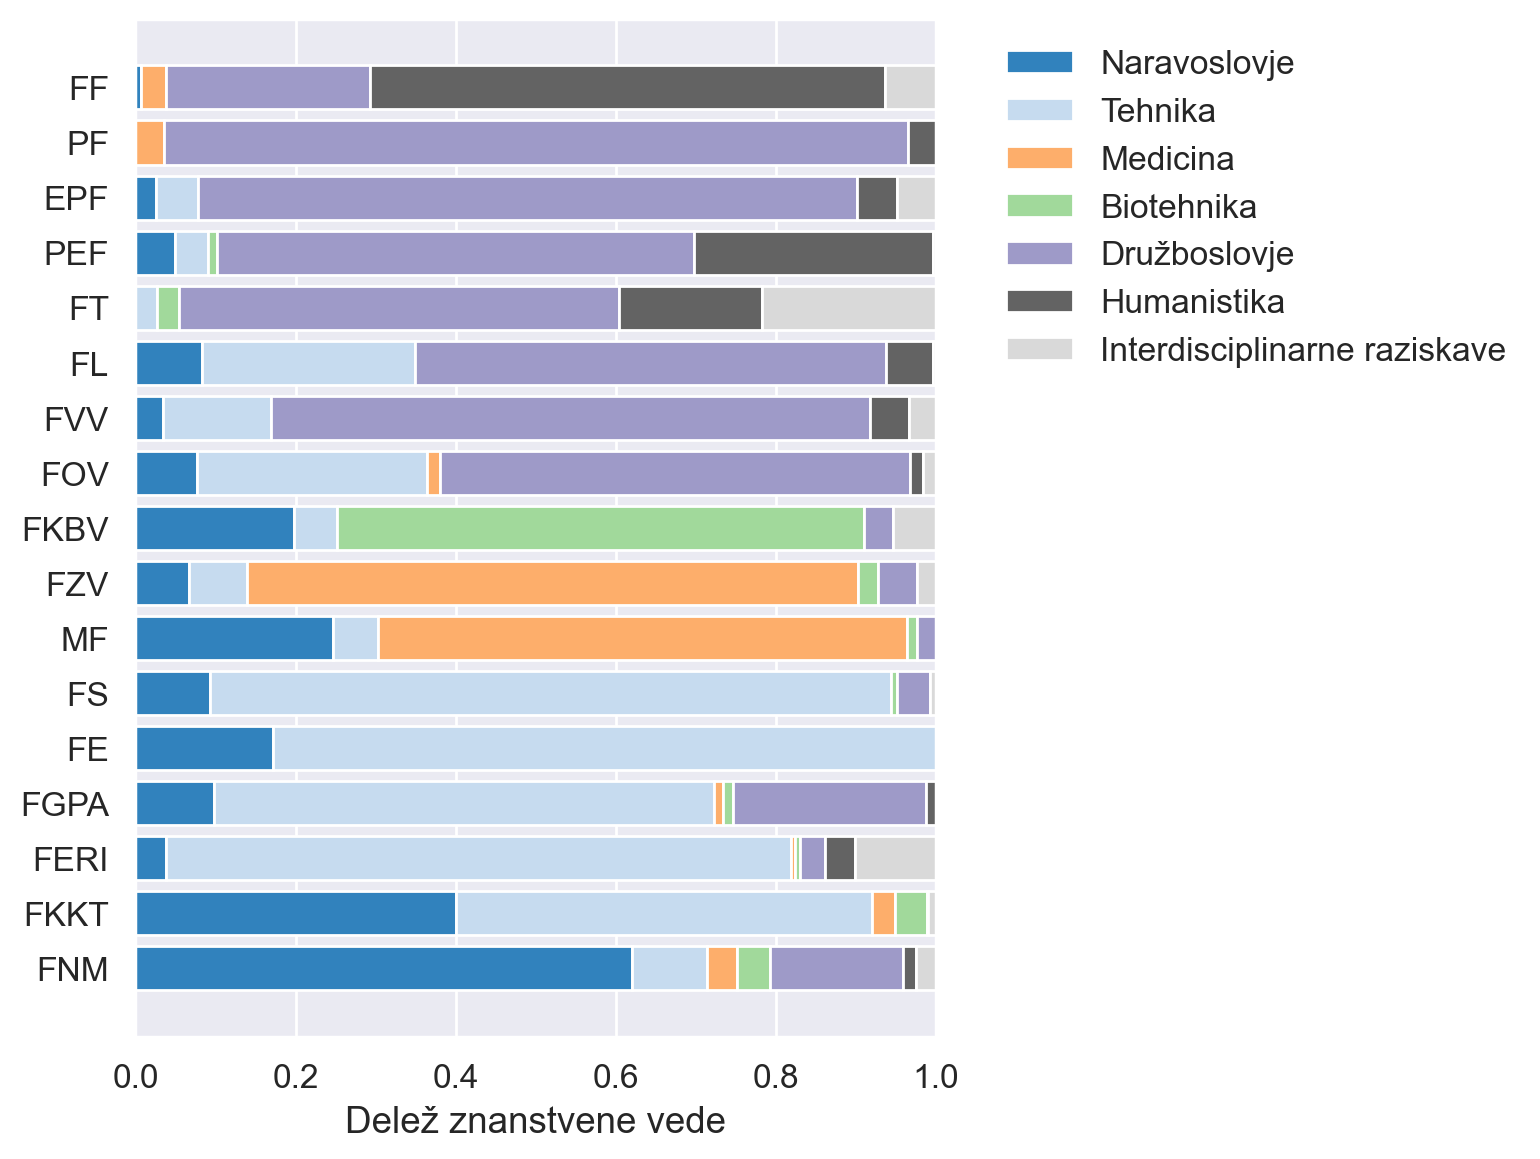

In [527]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (randomly generated for example purposes)
#faculties = [f'Faculty {i+1}' for i in range(17)]
fields = ['Naravoslovje', 'Tehnika', 'Medicina', 'Biotehnika', 'Družboslovje', 'Humanistika', 'Interdisciplinarne raziskave']

# Example vectors (replace with your actual data)
#data = np.random.dirichlet(np.ones(7), size=17)
data = np.array(resvec)

# Sorting faculties by their dominant research field for better visualization
dominant_field = np.argmax(data, axis=1)
sort_order = np.argsort(dominant_field)
sorted_data = data[sort_order]
sorted_faculties = [faculties[i] for i in sort_order]

# Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
left = np.zeros(len(sorted_faculties))

colors = plt.cm.tab20c(np.linspace(0, 1, len(fields)))

for idx, (field, color) in enumerate(zip(fields, colors)):
    ax.barh(sorted_faculties, sorted_data[:, idx], left=left, color=color, label=field)
    left += sorted_data[:, idx]

ax.set_xlabel('Delež znanstvene vede')
#ax.set_title('Distribution of Research Activity Across Faculties')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [24]:
fields = pd.read_excel("arrs_klasifikacija.xlsx",sheet_name="področja",header=None,dtype=str)
#kys = ('employs','cit','classificationFrascati','evaluation',"programs")
kys = ('employs','cit','classificationFrascati','evaluation')
vede = pd.read_excel("arrs_klasifikacija.xlsx",sheet_name="vede",header=None,dtype=str)

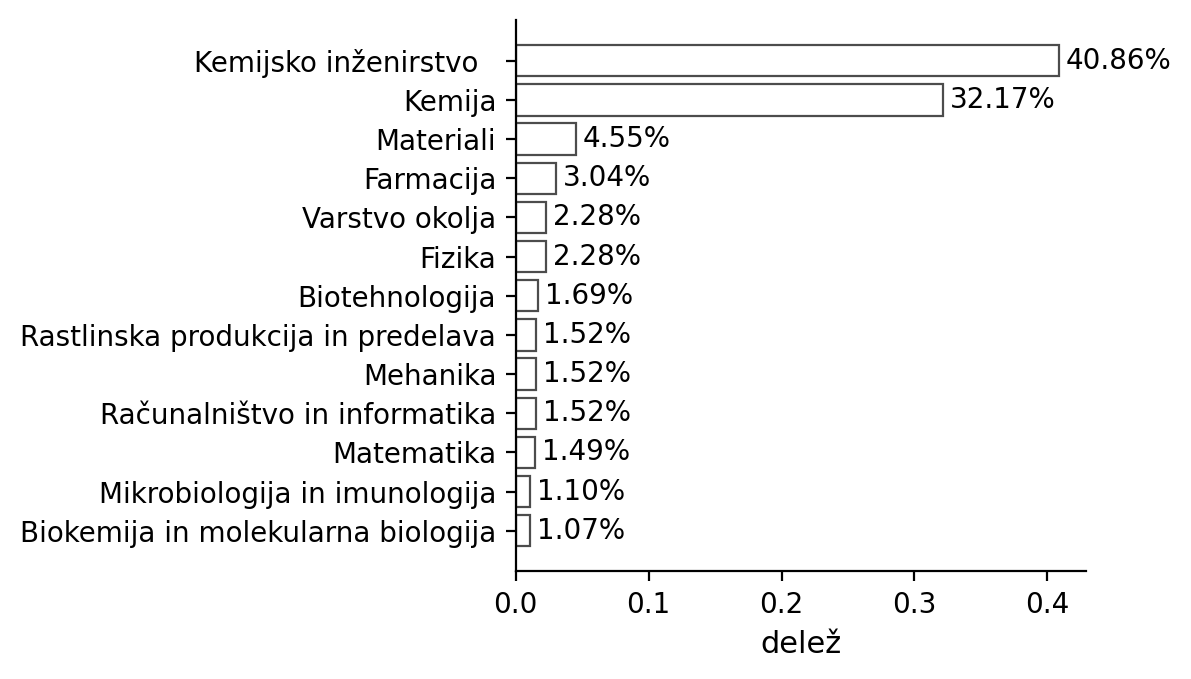

In [239]:
#### RAZISKOVALNA PODROČJA ####

faculty = 'FKKT'

df_faculty = df[df['Kratek naziv OE 2'] == faculty]
vec_fields_weight = {}
vec_fields = {}
c = 0
f = 0
id = []
weights = []
fields_labels = []
fields_values = []

for index, row in df_faculty.iterrows():
    c += 1
    f += row['Delež DM utež']
    weights.append(row['Delež DM utež'])
    id.append(row['ARRS šifra'])
    r = row['raziskovalno področje']
    r = list([x for x in ast.literal_eval(r)])
    #print(r)
    #r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
    q = row['Delež DM utež']

    for fld in r:
        if fld not in vec_fields_weight:
            vec_fields_weight[fld] = q
            vec_fields[fld] = 1

        else:
            vec_fields_weight[fld] += q
            vec_fields[fld] += 1

# sort by value
vec_fields_weight = dict(sorted(vec_fields_weight.items(), key=lambda item: item[1], reverse=True))
# normalize
vec_fields_weight = {k: v / sum(vec_fields_weight.values()) for k, v in vec_fields_weight.items()}

for k,v in vec_fields_weight.items():
    if k in fields[0].values and v > 0.01:
        #print(k,fields[fields[0] == k][1].values[0], v)
        fields_labels.append(fields[fields[0] == k][1].values[0])
        fields_values.append(v)

"""
fields_labels = [
    'Gradbeništvo',
    'Promet',
    'Arhitektura in oblikovanje',
    'Urbanizem',
    'Mehanika',
    'Matematika',
    'Fizika'
]

fields_values = [
    0.2982318064021013,
    0.23297638792910727,
    0.12919278871150824,
    0.10252322275460748,
    0.05681777095165807,
    0.04583849154070965,
    0.03099151142817713
]
"""


# Izris grafa
plt.figure(figsize=(6, 3.5))
bars = plt.barh(fields_labels[::-1], fields_values[::-1], color='white', edgecolor='black', linewidth=.8, alpha=0.7)

#plt.title('Porazdelitev raziskovalne dejavnosti - Fakulteta FGPA', fontsize=14, weight='bold')
plt.xlabel('delež', fontsize=11)
#plt.ylabel('Raziskovalno področje', fontsize=12)

# Dodaj vrednosti na graf
for bar in bars:
    plt.text(bar.get_width()+0.005, bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2%}', va='center')

#plt.grid(axis='x', linestyle='--', alpha=0.7)
# frame off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
# no x ticks
#plt.gca().xaxis.set_ticks_position('none')
# no x values
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_ticks_position('none')
plt.tight_layout()
plt.show()

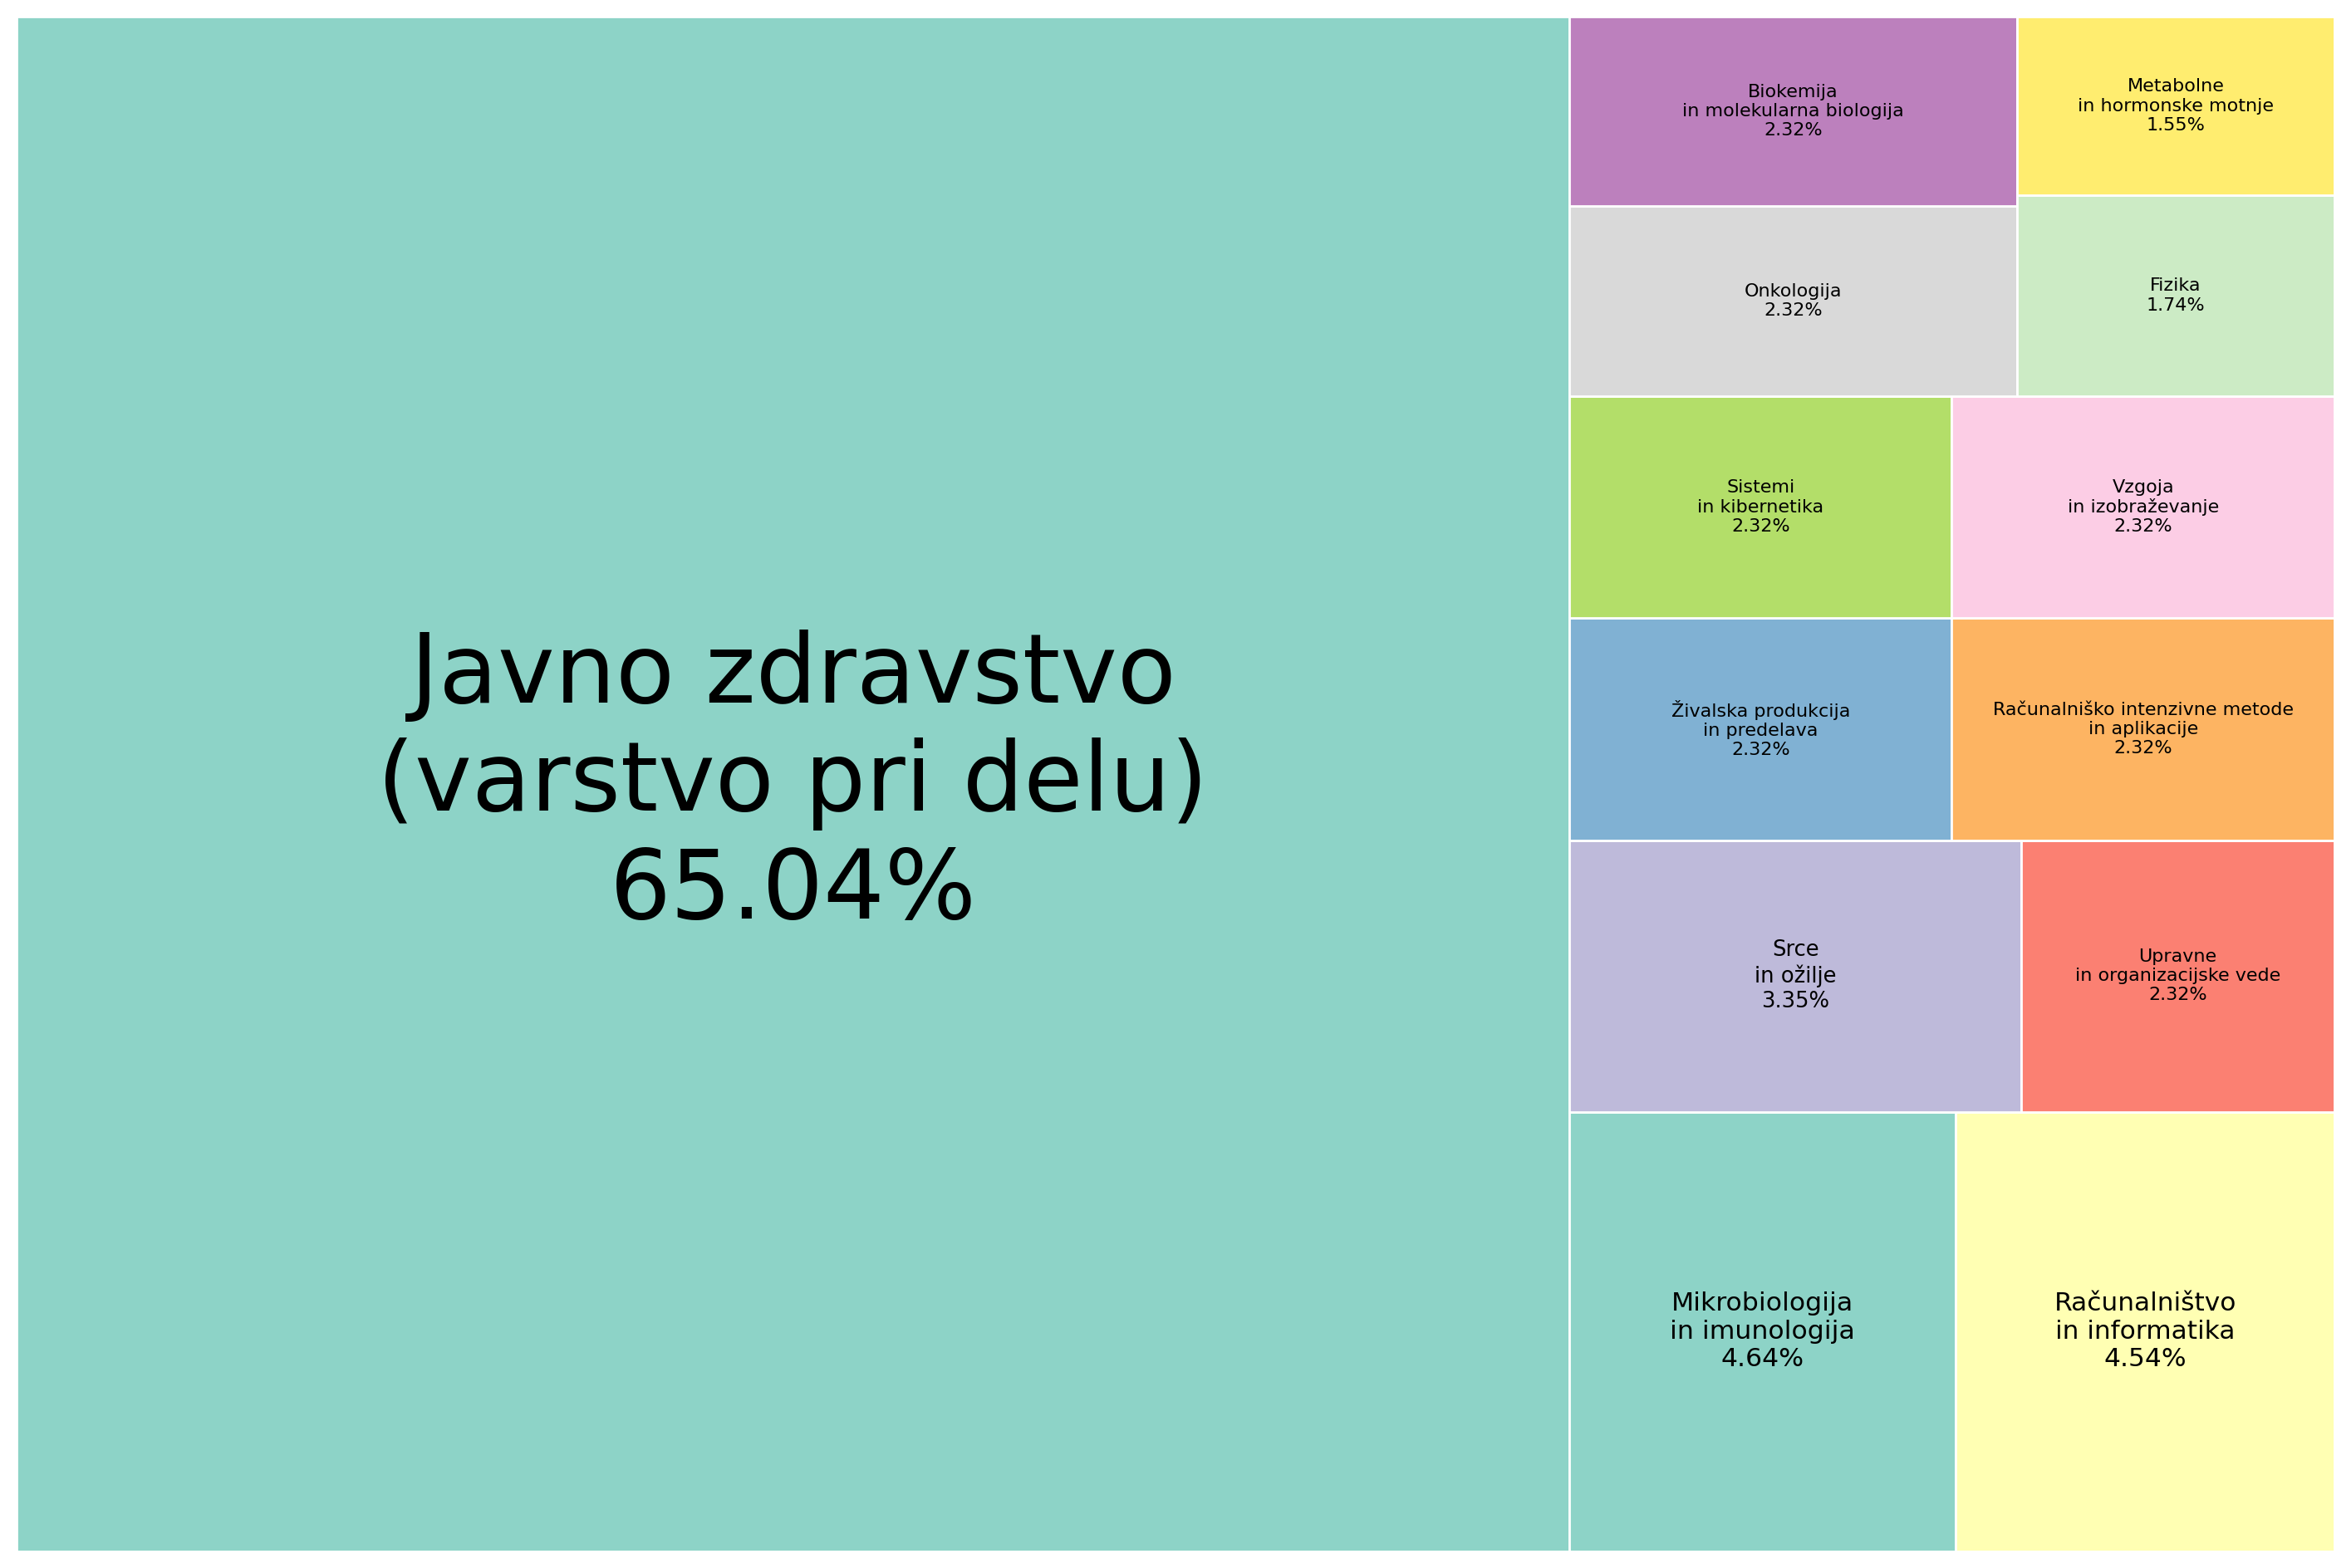

In [262]:
import matplotlib.pyplot as plt
import squarify

#### RAZISKOVALNA PODROČJA ####

faculty = 'FZV'

df_faculty = df[df['Kratek naziv OE 2'] == faculty]
vec_fields_weight = {}
vec_fields = {}
c = 0
f = 0
id = []
weights = []
fields_labels = []
fields_values = []

for index, row in df_faculty.iterrows():
    c += 1
    f += row['Delež DM utež']
    weights.append(row['Delež DM utež'])
    id.append(row['ARRS šifra'])
    r = row['raziskovalno področje']
    r = list([x for x in ast.literal_eval(r)])
    #print(r)
    #r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
    q = row['Delež DM utež']

    for fld in r:
        if fld not in vec_fields_weight:
            vec_fields_weight[fld] = q
            vec_fields[fld] = 1

        else:
            vec_fields_weight[fld] += q
            vec_fields[fld] += 1

# sort by value
vec_fields_weight = dict(sorted(vec_fields_weight.items(), key=lambda item: item[1], reverse=True))
# normalize
vec_fields_weight = {k: v / sum(vec_fields_weight.values()) for k, v in vec_fields_weight.items()}

for k,v in vec_fields_weight.items():
    if k in fields[0].values and v > 0.01:
        #print(k,fields[fields[0] == k][1].values[0], v)
        fields_labels.append(fields[fields[0] == k][1].values[0])
        fields_values.append(v)



# Insert line breaks at 'in'
fields_labels_modified = [label.replace(' in ', '\nin ') for label in fields_labels]
fields_labels_modified = [label.replace(' (', '\n(') for label in fields_labels_modified]


# Convert values to percentages
fields_percentages = [value * 100 for value in fields_values]
labels_with_values = [
    f'{label}\n{value:.2f}%'
    for label, value in zip(fields_labels_modified, fields_percentages)
]

# Generate plot coordinates
rects = squarify.normalize_sizes(fields_values, 100, 100)
rects = squarify.squarify(rects, 0, 0, 100, 100)

# Plotting the treemap with dynamic font size
plt.figure(figsize=(18, 12))
ax = plt.gca()

for i, rect in enumerate(rects):
    fontsize = max(8, 0.25 * (rect['dx'] + rect['dy']))  # scaling font size by box dimensions
    color_index = i / len(fields_labels_modified)
    ax.add_patch(plt.Rectangle((rect['x'], rect['y']), rect['dx'], rect['dy'],
                               facecolor=plt.cm.Set3(color_index),
                               edgecolor='white'))
    plt.text(rect['x'] + rect['dx']/2, rect['y'] + rect['dy']/2, labels_with_values[i],
             ha='center', va='center', fontsize=fontsize)

#plt.title('Treemap with Dynamically Scaled Labels', fontsize=16)
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()


In [107]:
- (p * np.log(p)).sum() / np.log(len(p))

np.float64(0.7042910303418438)

In [77]:
-([1/10]*10 * np.log([1/10]*10)).sum()

np.float64(2.3025850929940455)

In [81]:
p

array([0.26150121, 0.20338983, 0.11622276, 0.11622276, 0.08716707,
       0.05811138, 0.02905569, 0.02905569, 0.02905569, 0.02905569,
       0.02905569, 0.01210654])

In [109]:
faculties

array(['FKKT', 'FS', 'FOV', 'EPF', 'FGPA', 'MF', 'FERI', 'FF', 'PF',
       'FVV', 'FKBV', 'FL', 'FT', 'FNM', 'PEF', 'FZV', 'FE'], dtype='<U4')

In [ ]:
data_fields = {}
rows = []

for faculty in faculties:
    df_faculty = df[df['Kratek naziv OE 2'] == faculty]
    vec_fields_weight = {}
    vec_fields = {}
    c = 0
    f = 0
    id = []
    weights = []

    for index, row in df_faculty.iterrows():
        c += 1
        f += row['Delež DM utež']
        weights.append(row['Delež DM utež'])
        id.append(row['ARRS šifra'])
        r = row['raziskovalno področje']
        r = list([x for x in ast.literal_eval(r)])
        #print(r)
        #r = list(set([int(x[0]) for x in ast.literal_eval(r)]))
        q = row['Delež DM utež']

        for fld in r:
            if fld not in vec_fields_weight:
                vec_fields_weight[fld] = q
                vec_fields[fld] = 1

            else:
                vec_fields_weight[fld] += q
                vec_fields[fld] += 1

    # sort by value
    vec_fields_weight = dict(sorted(vec_fields_weight.items(), key=lambda item: item[1], reverse=True))
    # normalize
    vec_fields_weight = {k: v / sum(vec_fields_weight.values()) for k, v in vec_fields_weight.items()}
    
    data_fields[faculty] = vec_fields_weight

    for k,v in vec_fields_weight.items():
    if k in fields[0].values and v > 0.01:
        print(k,fields[fields[0] == k][1].values[0], v)


In [280]:
data_fields['FNM']

{'1.01': 0.22712194229512742,
 '1.03': 0.21626033940885075,
 '1.02': 0.15919544159312754,
 '5.01': 0.14336653167949617,
 '4.06': 0.03321562774892234,
 '2.11': 0.026157306852276338,
 '1.07': 0.02015081416767955,
 '7.02': 0.019929376649353403,
 '1.05': 0.019929376649353403,
 '2.07': 0.019929376649353403,
 '3.08': 0.019098985955630345,
 '1.04': 0.019023495892564614,
 '5.04': 0.01162546971212282,
 '6.10': 0.009964688324676702,
 '2.21': 0.009964688324676702,
 '5.02': 0.009964688324676702,
 '2.04': 0.009964688324676702,
 '3.01': 0.009964688324676702,
 '2.06': 0.004982344162338351,
 '2.19': 0.00296052334283873,
 '6.12': 0.002662456802104569,
 '3.07': 0.002075976734307646,
 '2.02': 0.001660781387446117,
 '6.07': 0.0008303906937230585}

In [305]:
maxp = 0
for faculty in faculties:
    p = data_fields[faculty].values()
    if len(p) > maxp:
        maxp = len(p)
    p = np.array(list(p))
    ep = -np.sum(p * np.log(p)) / np.log(len(p))
    s = np.array(list(Counter([k[0] for k in data_fields[faculty].keys()]).values()))
    q = s/s.sum()
    eq = -np.sum(q * np.log(q)) / np.log(len(q))
    varsci = len(list(set([k[0] for k in data_fields[faculty].keys()])))/7.
    print(faculty, varsci, ep, eq, varsci * ep, ep * eq)
print(maxp)

FKKT 0.8571428571428571 0.5785394951919409 0.8386483700653622 0.4958909958788065 0.4851912046611587
FS 0.7142857142857143 0.7652428005527214 0.7651937215343917 0.546602000394801 0.5855589864323372
FOV 0.8571428571428571 0.6193505269022305 0.911188669681059 0.5308718802019118 0.5643451826743063
EPF 0.7142857142857143 0.4829985423612473 0.881353453268883 0.34499895882946235 0.4256924332339222
FGPA 0.8571428571428571 0.7042910303418438 0.8106352968964645 0.6036780260072947 0.5709231684826774
MF 0.7142857142857143 0.8583790975824238 0.8848616689990428 0.6131279268445885 0.7595467609206757
FERI 1.0 0.624329268968742 0.8016834734494194 0.624329268968742 0.5005144569229979
FF 0.7142857142857143 0.8602657625818779 0.7876520238845568 0.6144755447013414 0.6775900689762078
PF 0.42857142857142855 0.3201605708006067 0.946394630357186 0.13721167320026 0.3029982450577859
FVV 0.7142857142857143 0.8533536452013951 0.8437590816619513 0.6095383180009966 0.7200248880080078
FKBV 0.7142857142857143 0.695759

In [321]:
maxN1 = 7
maxN2 = maxp
interdisciplinarity = {}
for faculty in faculties:
    p = data_fields[faculty].values()
    p = np.array(list(p))
    H2 = -np.sum(p * np.log(p)) / np.log(len(p))
    N2 = len(p)
    s = np.array(list(Counter([k[0] for k in data_fields[faculty].keys()]).values()))
    q = s/s.sum()
    N1 = len(q)
    H1 = -np.sum(q * np.log(q)) / np.log(len(q))
    varsci = len(list(set([k[0] for k in data_fields[faculty].keys()])))/7.
    #print(faculty, N1, N2,N1/maxN1, N2/maxp, H1, H2)
    print(faculty, H1 * H2 * N1/maxN1 * N2/maxp)
    interdisciplinarity[faculty] = [N1,N2,N1/maxN1, N2/maxp, float(H1),float(H2),float(H1 * H2 * N1/maxN1 * N2/maxp) ]

FKKT 0.3542665938795762
FS 0.3408015264950111
FOV 0.21498864101878337
EPF 0.11261704582907993
FGPA 0.3624909006239222
MF 0.4822519116956672
FERI 0.5005144569229979
FF 0.322661937607718
PF 0.019237983813192753
FVV 0.22857932952635168
FKBV 0.27571278655322146
FL 0.20242971554855668
FT 0.26934393592561273
FNM 0.573984299167249
PEF 0.3730554644431852
FZV 0.23985457690770498
FE 0.06511036138360406


In [322]:
interdisciplinarity['FKKT']

[6,
 23,
 0.8571428571428571,
 0.8518518518518519,
 0.8386483700653622,
 0.5785394951919409,
 0.3542665938795762]

In [323]:
# sort interdisciplinarity by 4th column
interdisciplinarity = dict(sorted(interdisciplinarity.items(), key=lambda item: item[1][6], reverse=True))

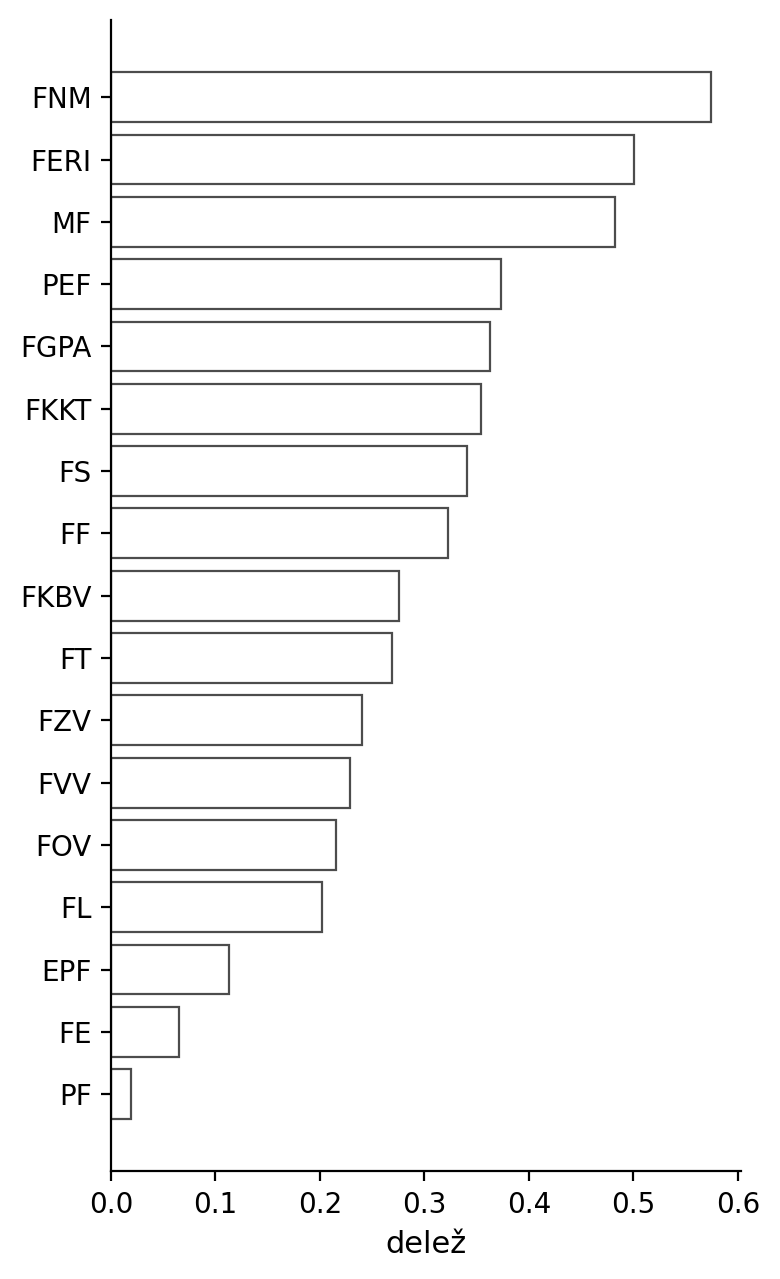

In [332]:
fields_labels = list(interdisciplinarity.keys())
fields_values = list([v[6] for k,v in interdisciplinarity.items()])

# Izris grafa
plt.figure(figsize=(4, 6.5))
bars = plt.barh(fields_labels[::-1], fields_values[::-1], color='white', edgecolor='black', linewidth=.8, alpha=0.7)

#plt.title('Porazdelitev raziskovalne dejavnosti - Fakulteta FGPA', fontsize=14, weight='bold')
plt.xlabel('delež', fontsize=11)
#plt.ylabel('Raziskovalno področje', fontsize=12)

# Dodaj vrednosti na graf
#for bar in bars:
#    plt.text(bar.get_width()+0.005, bar.get_y() + bar.get_height() / 2,
#             f'{bar.get_width():.2%}', va='center')
    
# Dodaj vrednosti na graf


#for bar in bars:
#    plt.text(bar.get_width()+0.005, bar.get_y() + bar.get_height() / 2,
#             va='center')

#plt.grid(axis='x', linestyle='--', alpha=0.7)
# frame off
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
# no x ticks
#plt.gca().xaxis.set_ticks_position('none')
# no x values
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_ticks_position('none')
plt.tight_layout()

In [333]:
fields_labels

[np.str_('FNM'),
 np.str_('FERI'),
 np.str_('MF'),
 np.str_('PEF'),
 np.str_('FGPA'),
 np.str_('FKKT'),
 np.str_('FS'),
 np.str_('FF'),
 np.str_('FKBV'),
 np.str_('FT'),
 np.str_('FZV'),
 np.str_('FVV'),
 np.str_('FOV'),
 np.str_('FL'),
 np.str_('EPF'),
 np.str_('FE'),
 np.str_('PF')]

In [334]:
fields_values

[0.573984299167249,
 0.5005144569229979,
 0.4822519116956672,
 0.3730554644431852,
 0.3624909006239222,
 0.3542665938795762,
 0.3408015264950111,
 0.322661937607718,
 0.27571278655322146,
 0.26934393592561273,
 0.23985457690770498,
 0.22857932952635168,
 0.21498864101878337,
 0.20242971554855668,
 0.11261704582907993,
 0.06511036138360406,
 0.019237983813192753]

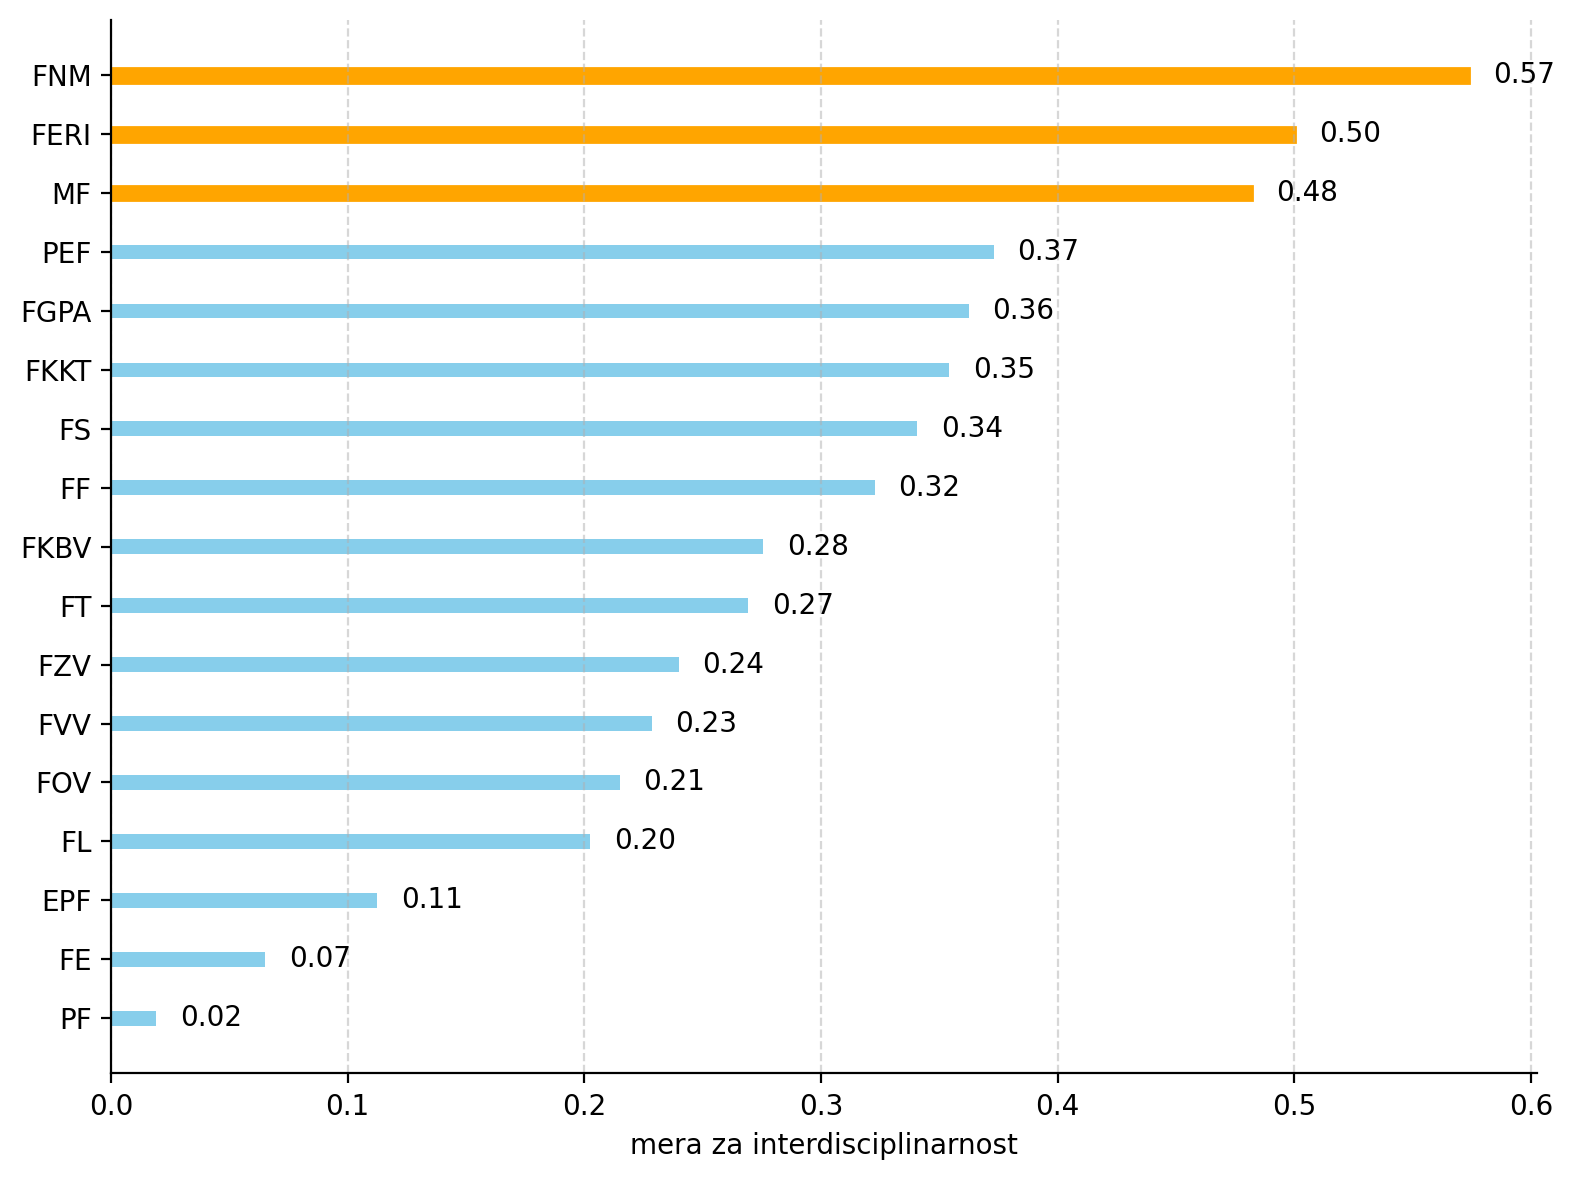

In [346]:
import matplotlib.pyplot as plt
import numpy as np

# Data
fields_labels = [
    'FNM', 'FERI', 'MF', 'PEF', 'FGPA', 'FKKT', 'FS', 'FF', 'FKBV', 'FT',
    'FZV', 'FVV', 'FOV', 'FL', 'EPF', 'FE', 'PF'
]
fields_values = [
    0.573984299167249, 0.5005144569229979, 0.4822519116956672, 0.3730554644431852,
    0.3624909006239222, 0.3542665938795762, 0.3408015264950111, 0.322661937607718,
    0.27571278655322146, 0.26934393592561273, 0.23985457690770498, 0.22857932952635168,
    0.21498864101878337, 0.20242971554855668, 0.11261704582907993, 0.06511036138360406,
    0.019237983813192753
]

# Sort data
sorted_indices = np.argsort(fields_values)
labels_sorted = [fields_labels[i] for i in sorted_indices]
values_sorted = [fields_values[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels_sorted, values_sorted, color='skyblue', height=0.25)

# Highlight top 3
for i in range(-1, -4, -1):
    bars[i].set_color('orange')

# Annotate values on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', va='center', fontsize=10)

# Style
plt.xlabel('mera za interdisciplinarnost')
#plt.title('Faculty Performance or Metric Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()
